# Topology of Learning in Neural Networks
This notebook is associated with the preprint arXiv:1903.....

The goal is to monitor the evolution of neural network weights during training by representing them as a Mapper graph. We consider several standard datasets: MNIST, Fashion-MNIST, CIFAR-10.

In [1]:
import numpy as np
import IPython
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers, regularizers, optimizers
from keras.callbacks import Callback

Using TensorFlow backend.


## Import and process data

### MNIST
28*28 images of hand-written digits. 

Benchmark: 90-99%. 

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Fashion-MINST
28*28 images of 10 classes of fashion articles:

("0-T-shirt/top","1-Trouser","2-Pullover","3-Dress","4-Coat","5-Sandal","6-Shirt","7-Sneaker","8-Bag","9-Ankle boot").

Benchmark: 90-96% (human performance: 83%).

https://github.com/zalandoresearch/fashion-mnist

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

### CIFAR-10
32*32 color images of 10 classes of objects:

("0-Airplane","1-Automobile","2-Bird","3-Cat","4-Deer","5-Dog","6-Frog","7-Horse","8-Ship","9-Truck")

Benchmark: 75-96%.

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

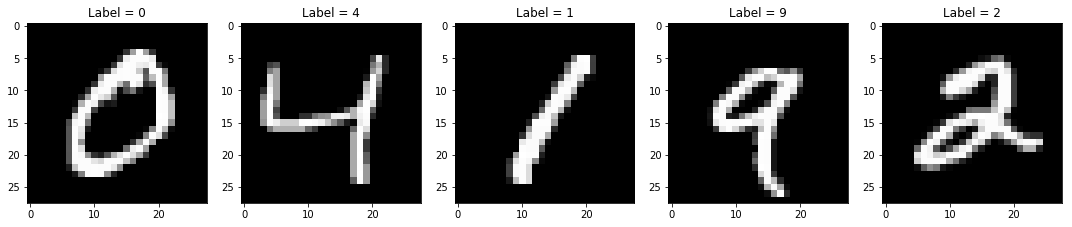

In [3]:
# Plot examples of images
fig = plt.figure(figsize=(15, 4))
rows, columns = 1, 5
for i in range(1, rows*columns +1):
    fig.add_subplot(rows, columns, i)
    img = X_train[i]
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title('Label = {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

In [4]:
# Normalize
X_train, X_test = X_train / 255.0, X_test / 255.0
# Flatten images into vectors of pixels
pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape(X_train.shape[0], pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], pixels).astype('float32')
print('Train shape: {}\nTest shape: {}'.format(X_train.shape, X_test.shape))
# Encode labels as one-hot vectors
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

Train shape: (60000, 784)
Test shape: (10000, 784)


## Train neural network with multiple layers

In [5]:
def train_model(X_train, y_train, X_test, y_test,
                neurons=[pixels, 30, 10],
                init=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=42),
                activation='sigmoid', l1=0.0, l2=0.0, 
                loss='categorical_crossentropy', learning_rate=0.01,
                epochs=5, batch_size=100, training_steps=500):
    
    activ = [activation]*(len(neurons)-2)+['softmax']

    model = Sequential()
    for n in range(1, len(neurons)):
        model.add(Dense(neurons[n],
                    input_dim=neurons[n-1], 
                    kernel_initializer=init,
#                     kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                    use_bias=False,
                    activation=activ[n-1]))

    model.compile(loss='categorical_crossentropy',    # categorical_crossentropy, 'mean_squared_error'
                  optimizer=optimizers.SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False),
                  metrics=['accuracy'])

    # Train model    #### Why do we often have val_acc > acc for the first few epochs???
    training_steps = training_steps    # Desired number of training steps (approximate)
    N_ws = round((len(X_train) * epochs) / (batch_size * training_steps))
    WSaver = SaveWeights(model, N_ws)
#     ConfSaver = SaveConfusion(model, N_ws)
    calback_list = [WSaver]
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=batch_size, callbacks=calback_list, verbose=2)
    scores = model.evaluate(X_test, y_test, verbose=0)

    W_layer = {}
    for n in range(len(model.layers)):
        W_layer[n] = WSaver.weights_layer[n]
    steps = len(W_layer[0])
    # Lists of vectors of weights for each neuron for each training step
    X_layer = {}
    for n in range(len(model.layers)):
        X_layer[n] = np.squeeze([W_layer[n][i][:, [j]] for i in range(steps) for j in range(neurons[n+1])])
    # Labels = [neuron number, training step]
    y_layer = {}
    for n in range(len(model.layers)):
        y_layer[n] = np.array([[j, i] for i in range(steps) for j in range(neurons[n+1])])
    # Number of weight matrices saved = 1 + (60000 * epochs) / (batch_size * N_ws)
    print('Training steps: {}'.format(steps))

    # Plot training & validation accuracy values  #### COLOR BY TRAINING STEP (VIRIDIS)
    plt.figure(figsize=(15, 4))
#     plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
#     plt.subplot(122)
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper right')
    plt.tight_layout()
    plt.show()
    
    return W_layer, X_layer, y_layer#, ConfSaver.confusions

# Callback function to save weights after each N mini-batches
class SaveWeights(Callback):
    def __init__(self, model, N):
        self.model = model
        self.N = N
        self.batch = 0
    def on_train_begin(self, logs={}):
        self.weights_layer = {}
        for n in range(len(self.model.layers)):
            self.weights_layer[n] = [self.model.layers[n].get_weights()[0]]
    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            for n in range(len(self.model.layers)):
                self.weights_layer[n].append(self.model.layers[n].get_weights()[0])
        self.batch += 1
        
# Callback function to save confusion matrix after each N mini-batches
# Slows down training significantly!
class SaveConfusion(Callback):
    def __init__(self, model, N):
        self.model = model
        self.N = N
        self.batch = 0
    def on_train_begin(self, logs={}):
        y_pred = self.model.predict(X_test)
        self.confusions = [confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))]
    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            y_pred = self.model.predict(X_test)
            self.confusions.append(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
        self.batch += 1

## PCA plots in 3d

In [6]:
from sklearn.decomposition import PCA
import plotly as py
import plotly.graph_objs as go
from IPython.display import IFrame
from IPython.display import display

def PCA_3d(XX, yy, filename='PCA.html', coloring='Step', size=2, opacity=0.5):
    
    X_pca = PCA(n_components=3).fit_transform(XX)
    
    if coloring == 'Acc':
        acc = history.history['val_acc']
        d_acc = [t - s for s, t in zip(acc, acc[1:])]
        color = np.repeat(d_acc, np.ceil(len(yy)/len(d_acc)))[-len(yy):]
        color = (color-min(color))/(max(color)-min(color))    # normalize
        color = [min(x, 0.5) for x in color]    # truncate for better visibility
    elif coloring == 'Step':
        color = yy[:,1]
        
    trace = go.Scatter3d(
        x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
        mode='markers',
        text=['Neuron: {}, Step: {}'.format(yy[i,0], yy[i,1]) for i in range(len(yy))],
        marker=dict(size=2,
                    color=color, 
                    colorscale='Viridis',
                    opacity=0.8))
    fig = go.Figure(data=[trace], layout=go.Layout(margin=dict(l=0,r=0,b=0,t=0)))
    py.offline.plot(fig, filename=filename, auto_open=False)

## Mapper graphs
From the high-dimensional point clouds of weights we now construct and visualize Mapper graphs using KeplerMapper.
https://github.com/MLWave/kepler-mapper

In [7]:
import kmapper as km
from sklearn.cluster import DBSCAN

# Create graph with PCA filter function
def graph_km(data, label, path, projection=PCA(3), title='Title', color_function='Step', 
                     nr_cubes=15, overlap_perc=0.5, clusterer=DBSCAN(1)):
    
    mapper = km.KeplerMapper(verbose=1)

#  projected_data=mapper.fit_transform(data, projection=sklearn.cluster.FeatureAgglomeration(n_components=n_components),
#                                      scaler=None)
    projected_data = mapper.fit_transform(data, projection=projection, scaler=None)
    graph = mapper.map(projected_data, data, nr_cubes=nr_cubes, overlap_perc=overlap_perc, clusterer=clusterer)      

    # Color function    #### How to change the color map?? (e.g. temperature colors)
    if color_function == 'Class':   ### Problem: a node with mixed 4s and 9s gets the color of class 6!!..
        color = label[:,0]
    elif color_function == 'Step':
        color = label[:,1]
    #### TO DO: color by node purity, by accuracy

    html = mapper.visualize(graph,
                            path_html=path,
                            title=title,
                            custom_tooltips=label,
                            color_function=color)

## Experimentations

In [ ]:
# Initialize weights
init = initializers.RandomNormal(mean=0.01, stddev=0.000001, seed=1)
# init = initializers.glorot_normal(seed=42)
# init = initializers.VarianceScaling(scale=0.0001, mode='fan_in', distribution='normal', seed=42)

# Architecture of the neural network
neurons = [pixels, 500, 500, 10]

# Train 
W_layer, X_layer, y_layer = train_model(X_train, y_train, X_test, y_test,
                                        neurons=neurons,
                                        init=init,
                                        activation='sigmoid',
                                        loss='categorical_crossentropy',
                                        l1=0.0, l2=0.0, 
                                        learning_rate=0.08,
                                        epochs=50, 
                                        batch_size=100,
                                        training_steps=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 4s - loss: 10.8737 - acc: 0.1005 - val_loss: 10.6427 - val_acc: 0.1032
Epoch 2/50
 - 4s - loss: 3.7780 - acc: 0.0998 - val_loss: 2.3090 - val_acc: 0.1009
Epoch 3/50
 - 4s - loss: 2.2740 - acc: 0.1506 - val_loss: 2.1763 - val_acc: 0.2177
Epoch 4/50
 - 4s - loss: 2.0671 - acc: 0.2475 - val_loss: 1.9433 - val_acc: 0.2766
Epoch 5/50
 - 4s - loss: 1.8731 - acc: 0.2940 - val_loss: 1.7736 - val_acc: 0.2956
Epoch 6/50
 - 3s - loss: 1.7579 - acc: 0.3195 - val_loss: 1.6872 - val_acc: 0.3257
Epoch 7/50
 - 4s - loss: 1.6927 - acc: 0.3362 - val_loss: 1.6474 - val_acc: 0.3328
Epoch 8/50
 - 4s - loss: 1.6582 - acc: 0.3425 - val_loss: 1.6068 - val_acc: 0.3514
Epoch 9/50
 - 3s - loss: 1.6358 - acc: 0.3478 - val_loss: 1.6112 - val_acc: 0.3561
Epoch 10/50
 - 3s - loss: 1.6224 - acc: 0.3513 - val_loss: 1.5932 - val_acc: 0.3485
Epoch 11/50
 - 3s - loss: 1.6138 - acc: 0.3560 - val_loss: 1.5940 - val_acc: 0.3619
Epoch 12/50
 - 3s - loss: 1.6032 

In [115]:
# 3d PCA plots
for lay_num in range(len(X_layer)):
    PCA_3d(X_layer[lay_num], y_layer[lay_num], coloring='Step',
             filename='PCA_{}.html'.format(lay_num), size=3, opacity=1.0)
    display(IFrame('PCA_{}.html'.format(lay_num), 1000, 800))

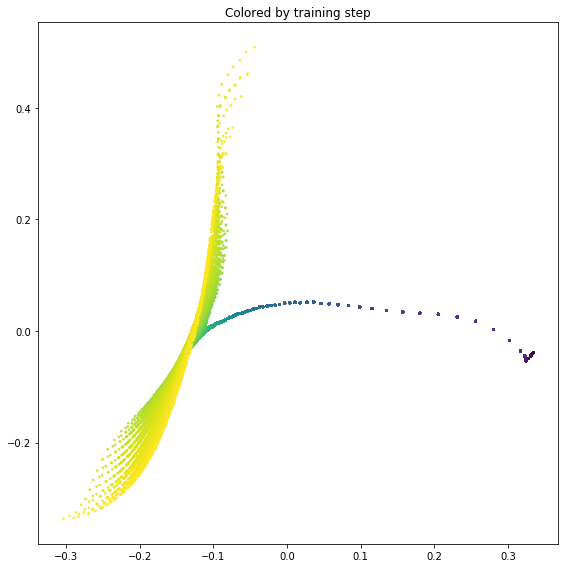

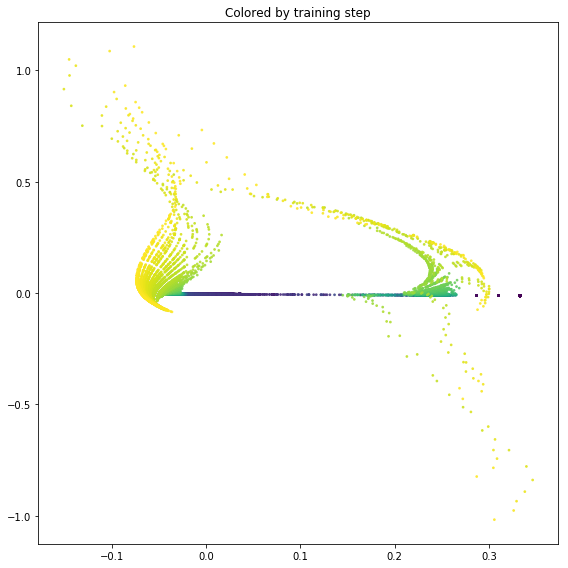

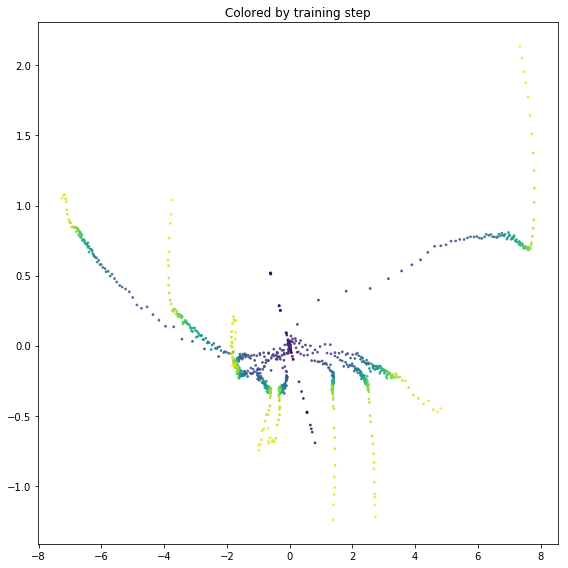

In [85]:
# 2d PCA plots
for lay_num in range(len(X_layer)):
    X_pca2 = PCA(n_components=2).fit_transform(X_layer[lay_num])
    plt.figure(figsize=(8,8))
#     plt.subplot(121)
    plt.scatter(X_pca2[:,0], X_pca2[:,1], s=3, c=y_layer[lay_num][:,1], cmap = plt.cm.get_cmap('viridis'), alpha=.8)
    plt.title('Colored by training step')
#     plt.subplot(122)
#     plt.scatter(X_pca2[:,0], X_pca2[:,1], s=4, c=y_layer[lay_num][:,0], cmap = plt.cm.get_cmap('jet'), alpha=.8)
#     plt.title('Colored by neuron')
    plt.tight_layout()
    plt.show()

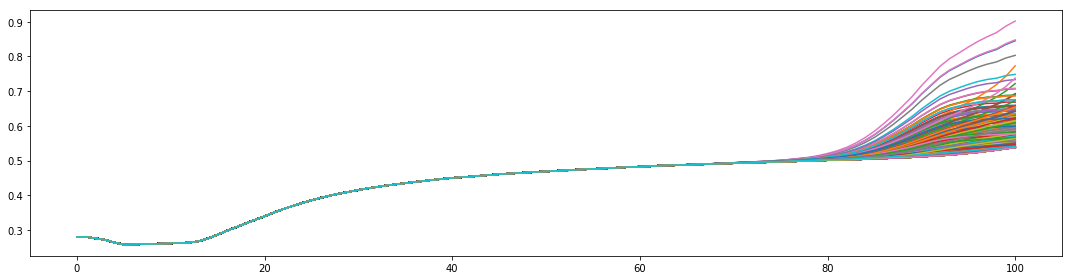

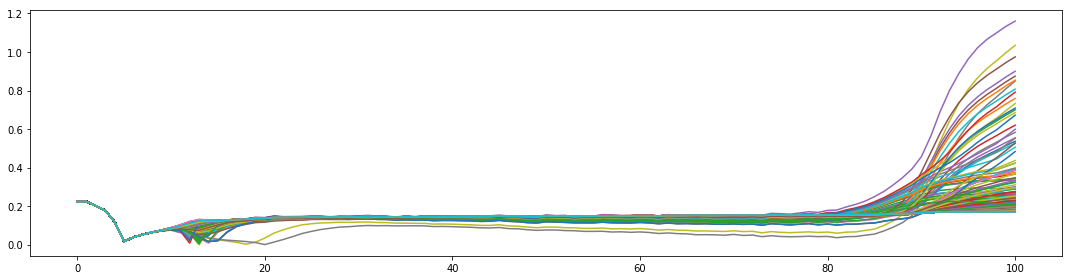

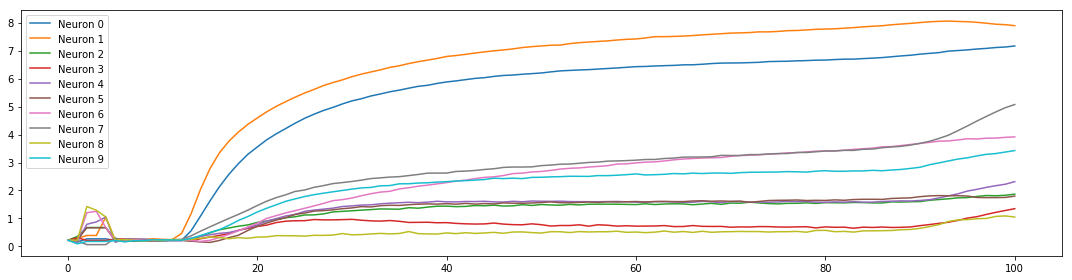

In [86]:
# Evolution of weight norms
for lay_num in range(len(X_layer)):
    fig = plt.figure(figsize=(15, 4))
    norms = {}
    steps = len(X_layer[lay_num])
    for i in range(neurons[lay_num+1]):
        norms[i] = [np.linalg.norm(X_layer[lay_num][j]) for j in range(i, steps, neurons[lay_num+1])]
        if neurons[lay_num+1] <= 10:
            plt.plot(norms[i], label='Neuron {}'.format(i))
            plt.legend()
        else:
            plt.plot(norms[i])
    plt.tight_layout()
    plt.show()

In [190]:
# from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering

In [201]:
# Reduce with PCA first (speeds up a bit, but blurs structure)
X_reduced = {}
for lay_num in range(len(X_layer)):
    X_reduced[lay_num] = PCA(n_components=20).fit_transform(X_layer[lay_num])

In [220]:
# Learning graph
lay_num = 0

color_fct = 'Step'
proj = PCA(3)  #'l2norm' #PCA(3)
nr_cubes = 20
overlap_perc = 0.99
clusterer = DBSCAN(eps=0.1, min_samples=2)

graph_km(X_reduced[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer {} (color by {})'.format(lay_num, color_fct),
         path='Graph_{}.html'.format(lay_num),
         color_function=color_fct, 
         nr_cubes=nr_cubes,
         overlap_perc=overlap_perc,
         clusterer=clusterer)

IPython.display.IFrame('Graph_{}.html'.format(lay_num), 1000, 800)

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20100, 20)

..Projecting data using: 
	PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Mapping on data shaped (20100, 20) using lens shaped (20100, 3)

Creating 8000 hypercubes.

Created 5982 edges and 975 nodes in 0:00:11.626450.
Wrote visualization to: Graph_0.html


In [218]:
# Learning graph
lay_num = 1

color_fct = 'Step'
proj = 'l2norm'    #[370,450,320] #'dist_mean' #PCA(3)
nr_cubes = 25
overlap_perc = 0.99
clusterer = DBSCAN(eps=0.1, min_samples=2)

graph_km(X_reduced[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer {} (color by {})'.format(lay_num, color_fct),
         path='Graph_{}.html'.format(lay_num),
         color_function=color_fct, 
         nr_cubes=nr_cubes,
         overlap_perc=overlap_perc,
         clusterer=clusterer)

IPython.display.IFrame('Graph_{}.html'.format(lay_num), 1000, 800)

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20100, 20)

..Projecting data using: l2norm
Mapping on data shaped (20100, 20) using lens shaped (20100, 1)

Creating 25 hypercubes.

Created 76 edges and 77 nodes in 0:00:02.940906.
Wrote visualization to: Graph_1.html


In [217]:
# Learning graph
lay_num = 2

color_fct = 'Step'
proj = 'l2norm'    #[370,450,320] #'dist_mean' #PCA(3)
nr_cubes = 25
overlap_perc = 0.99
clusterer = DBSCAN(eps=0.5, min_samples=2)

graph_km(X_reduced[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer {} (color by {})'.format(lay_num, color_fct),
         path='Graph_{}.html'.format(lay_num),
         color_function=color_fct, 
         nr_cubes=nr_cubes,
         overlap_perc=overlap_perc,
         clusterer=clusterer)

IPython.display.IFrame('Graph_{}.html'.format(lay_num), 1000, 800)

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2010, 20)

..Projecting data using: l2norm
Mapping on data shaped (2010, 20) using lens shaped (2010, 1)

Creating 25 hypercubes.

Created 84 edges and 85 nodes in 0:00:00.103740.
Wrote visualization to: Graph_2.html


# Observations

### Zero initialization and branching
(only seems to work with sigmoid activation: why?)

Input weights take time to differentiate (branch out). 
When only N "buds" (ends of branches) are visible in the graph, a similar accuracy can be obtained with only N hidden neurons.
This suggests that weight graphs could be used to adjust the architecture of neural nets...

(Adam optimizer struggles to use more than 2 neurons! Maybe lr too small?)

Find hyperparameters that enhance budding! This seems to be directly correlated with test accuracy.

Note: the Mapper parameters have to allow for budding branches: high nr_cubes, low overlap_perc, low eps...

The shape of the output PCA plot is very constant. Does it depend on order of X_train? Try shuffling!

What is the mechanism of branching? What triggers it and why?

Jumps in accuracy are associated with branchings, but also with "kinks", i.e. changes of direction of branches. 
Unfortunately, these kinks can't be capture by the graph... (or maybe in a subtle change in point density, or in triangles?)


### Normal initialization
Weights are well differentiated from the start (so the capacity is used more fully). This also gives better accuracy. The stddev can be minuscule.

The deconnection of the branches from the start implies that overlap_perc and eps should be quite high in order to reconnect them...

When initialized with a large stddev=0.5, the input weights barely change during training.

Away from mean=0.0, most weights struggle to learn.

With linear activation, the output buds are fuzzy.

There seems to be 2 distinct phases (with 100s of neurons, tiny stddev, small lr):
1. weights first evolve in parallel along some sort of smooth manifold (artefact of PCA?)
2. they then shoot off in their own squiggly directions.

Regions of parallel evolution give rise to densely connected grids in the graph.

With only one hidden layer, there is no visible manifold, only chaotic trajectories. 



### PCA plots

In PCA plots, branches become increasingly fuzzy towards their extremities (this could be because they are evolving in different directions). Can this be used to assess their quality?




# APPENDIX

### Plot incoming weights to a given neuron as an image

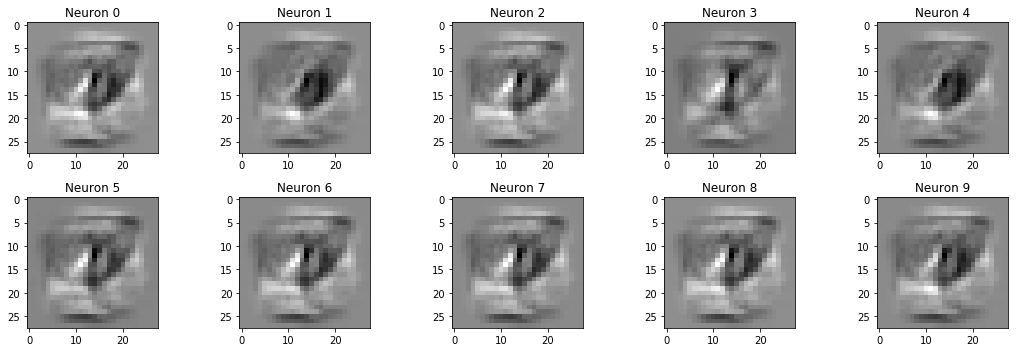

In [87]:
# Plot weights of a hidden neuron as 2d "filter"
fig = plt.figure(figsize=(15, 5))
rows, columns  = 2, 5
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    vec = W_layer[0][-1][:,i]
    vec = (vec - min(vec))/(max(vec)-min(vec))
    img = vec.reshape(28,28)    # For MNIST and Fashion-MNIST
#     img = 255 - (vec.reshape(32,32,3)*255).astype(np.uint8)    # For CIFAR-10
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title('Neuron {}'.format(i))
plt.tight_layout()
plt.show()

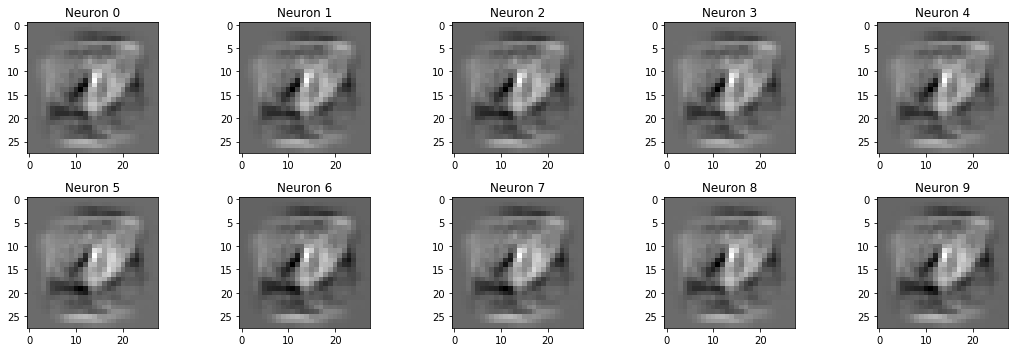

In [89]:
from sklearn.preprocessing import normalize
# Plot weighted superposition of 2d filters for each output neuron
### There is no strong rationale for the superposition...
### [TO DO: take into account activation functions!?]
fig = plt.figure(figsize=(15, 5))
rows, columns  = 2, 5
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    neur = i + 0
    mat = W_layer[0][-1] * W_layer[1][-1][:,neur]
#     mat = normalize(mat, axis=1)
    img = mat.sum(axis=1).reshape(28,28)
#     img = 255 - (mat.sum(axis=1).reshape(32,32,3)*255).astype(np.uint8)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title('Neuron {}'.format(neur))
plt.tight_layout()
plt.show()

### Coordinates along weight manifold

In [109]:
# Get list of neurons ordered by a PCA direction
X_pca = PCA(n_components=3).fit_transform(X_layer[0])
step = 100    # Choose a training step for which the neurons are nicely aligned along a PCA direction
dir_pca = 1    # x,y,z
ar = np.hstack((X_pca[100*step:100*(step+1)], y_layer[0][100*step:100*(step+1)]))
neuron_list = ar[ar[:,dir_pca].argsort()][:,3].astype(int)

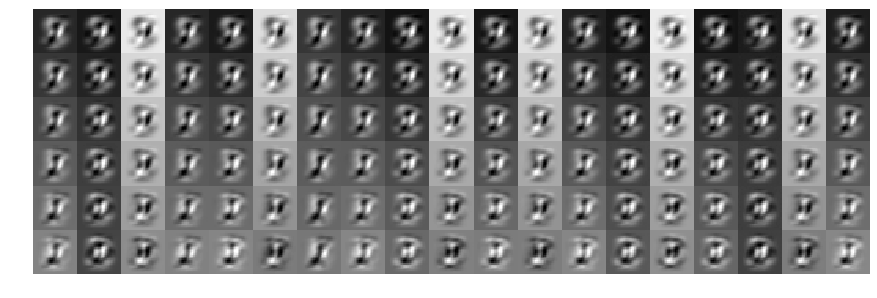

In [112]:
img_rows = ()
for step in range(90,101,2):
    imgs = ()
    skip = 5
    for i in range(skip, len(neuron_list), skip):
        img = W_layer[0][step][:,neuron_list[i-skip]] - W_layer[0][step][:,neuron_list[i]]
        img = (img - min(img))/(max(img)-min(img))
        img = img.reshape(28,28)
#         img = 255 - (img.reshape(32,32,3)*255).astype(np.uint8)
        imgs = imgs + (img,)
#     imgs = imgs/np.linalg.norm(imgs)
    img_rows = img_rows + (np.hstack(imgs),)
img_mat = np.vstack(img_rows)

fig = plt.figure(figsize=(15, 15))
plt.imshow(img_mat, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

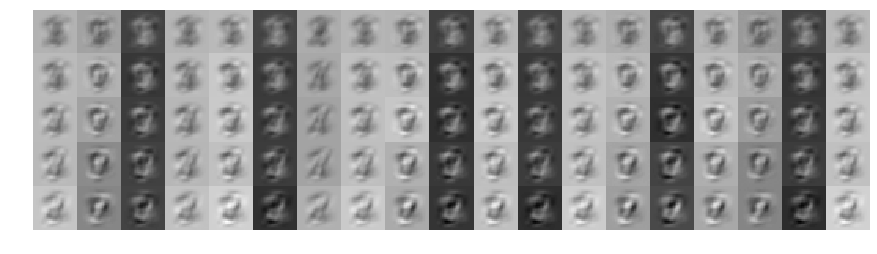

In [113]:
rows_diff = [img_rows[i+1] - img_rows[i] for i in range(len(img_rows)-1)]
img_mat_diff = np.vstack(rows_diff)

fig = plt.figure(figsize=(15, 15))
plt.imshow(img_mat_diff, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

### Animation of filter evolution

In [10]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


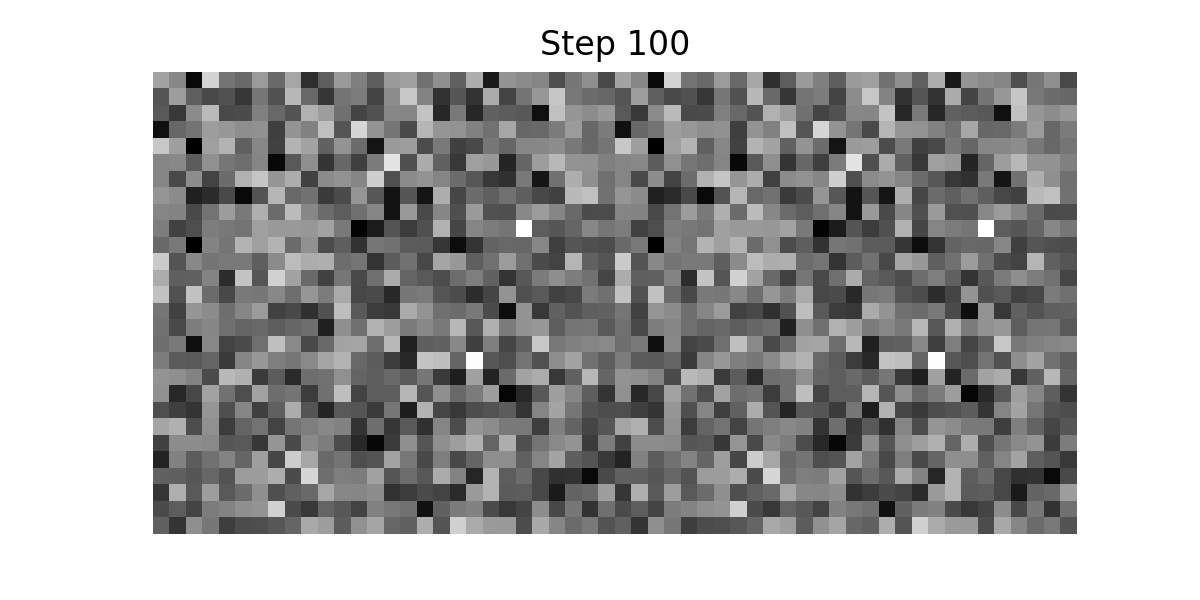

In [28]:
import matplotlib.animation as animation

# plt.style.use('dark_background')
fig = plt.figure(figsize=(6, 3))
    
def update(frame_number):
    N = 1 * (frame_number + 1)
    img0 = W_layer[0][N][:,0].reshape(28,28)
    img96 = W_layer[0][N][:,96].reshape(28,28)
    img64 = W_layer[0][N][:,64].reshape(28,28)
    plt.imshow(np.hstack((img0, img96, img64)), cmap=plt.get_cmap('gray'))
    plt.title('Step {}'.format(N))
    plt.axis('off')

# Construct the animation
animation = animation.FuncAnimation(fig, update, frames=100, interval=200, repeat=False)

plt.show()

### t-SNE 
(slow! Hard to get decent results...)

In [68]:
# t-SNE 3d
from sklearn.manifold import TSNE

def plot_tSNE(XX, yy, perplexity=30.0, filename='tSNE.html'):
    
    X_tsne = TSNE(n_components=3, 
                  perplexity=perplexity, 
                  early_exaggeration=12.0, 
                  learning_rate=200.0, 
                  n_iter=1000
                 ).fit_transform(XX)

    trace = go.Scatter3d(
        x=X_tsne[:,0], y=X_tsne[:,1], z=X_tsne[:,2],
        mode='markers',
        text=yy[:,0],
        marker=dict(size=6,
                    color=yy[:,1], 
                    colorscale='Jet',
                    opacity=0.1))
    fig = go.Figure(data=[trace], layout=go.Layout(margin=dict(l=0,r=0,b=0,t=0)))
    py.offline.plot(fig, filename=filename)

In [83]:
lay_num = 2

# X_pca = PCA(n_components=3).fit_transform(X_layer[lay_num])

plot_tSNE(X_layer[lay_num], y_layer[lay_num], perplexity=200, 
          filename='tSNE_{}.html'.format(lay_num))

Perplexity=5 in 28 sec
Perplexity=30 in 33 sec
Perplexity=50 in 37 sec
Perplexity=100 in 53 sec
Perplexity=200 in 91 sec
Perplexity=500 in 2e+02 sec


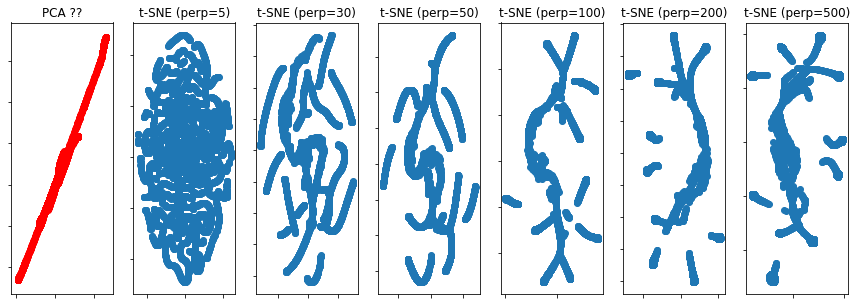

In [96]:
# t-SNE 2d

from matplotlib.ticker import NullFormatter
from time import time

n_components = 2
(fig, subplots) = plt.subplots(1, 5, figsize=(15, 4))
perplexities = [5, 30, 100, 200]

X = X_layer[2]

X_pca = PCA(n_components=2).fit_transform(X)

ax = subplots[0]
ax.set_title('PCA ??')
ax.scatter(X[:, 0], X[:, 1], c="r")
# ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("Perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("t-SNE (perp=%d)" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

### Evolution of weight distributions during training

IndexError: index 2002 is out of bounds for axis 0 with size 784

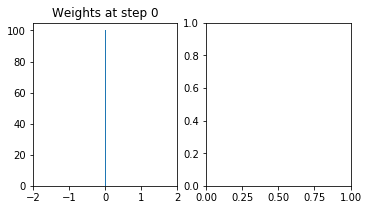

In [58]:
fig = plt.figure(figsize=(15, 3))
rows, columns  = 1, 5

WW = W_layer[len(W_layer)-1]
shift = int(steps/5)
x_lim = 2
bins = np.linspace(-x_lim,x_lim,100)

for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.hist(WW[i*shift].flatten(), bins)
    plt.title('Weights at step {}'.format(i*shift))
    plt.xlim(-x_lim, x_lim)
plt.tight_layout()
plt.show()

### Confusion matrix

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Compute confusion matrix
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

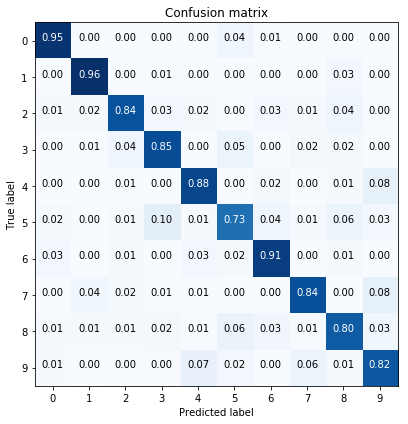

In [43]:
# Plot normalized confusion matrix
plt.figure(figsize=(15, 6))
plot_confusion_matrix(Confusions[-1], classes=range(10), normalize=True, title='Confusion matrix')
plt.show()

In [44]:
len(Confusions)

101

In [81]:
true_label = 9
conf_rows = {}
for i in range(10):
    conf_rows[i] = [Confusions[j][true_label][i] for j in range(len(Confusions))]

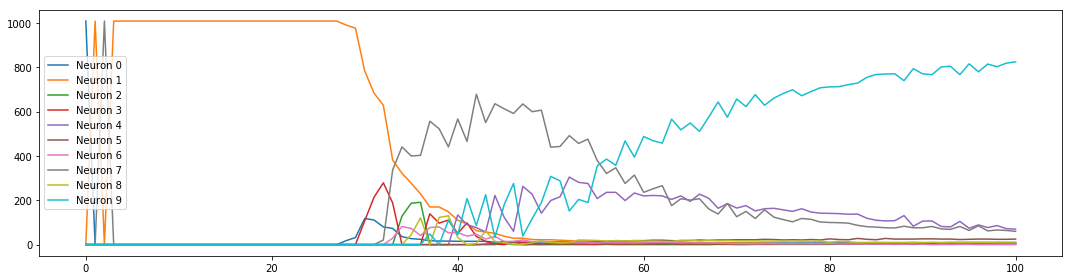

In [82]:
fig = plt.figure(figsize=(15, 4))
norms = {}
steps = len(X_layer[lay_num])
for i in range(10):
    plt.plot(conf_rows[i], label='Neuron {}'.format(i))
    plt.legend()
plt.tight_layout()
plt.show()

### NetworkX

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (5010, 100)

..Projecting data using: 
	PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Mapping on data shaped (5010, 100) using lens shaped (5010, 3)

Creating 8000 hypercubes.

Created 1029 edges and 302 nodes in 0:00:01.274971.


/Applications/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



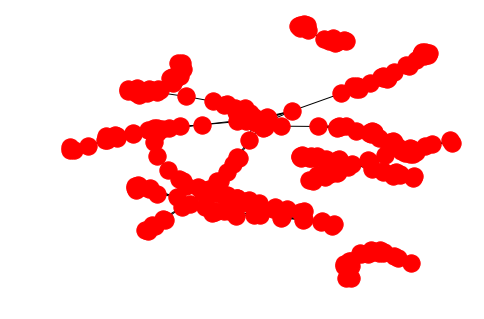

In [75]:
import networkx as nx

data = X_layer[2]

mapper = km.KeplerMapper(verbose=1)
projected_data = mapper.fit_transform(data, projection='l2norm', scaler=None)
graph = mapper.map(projected_data, data, nr_cubes=20, overlap_perc=0.5, clusterer=DBSCAN(0.3))

nx_graph = km.adapter.to_nx(graph)
nx.draw(nx_graph)

### Mapper algorithm illustration

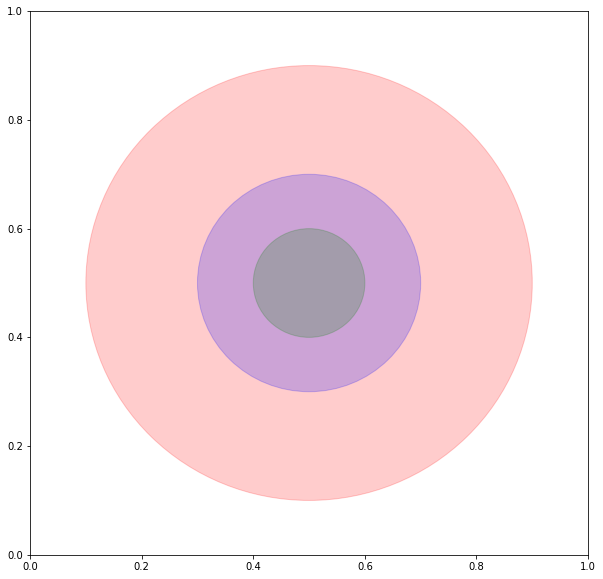

In [102]:
circle1 = plt.Circle((0.5, 0.5), 0.4, color='r', alpha=0.2)
circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue', alpha=0.2)
circle3 = plt.Circle((0.5, 0.5), 0.1, color='g', alpha=0.2)

fig, ax = plt.subplots(figsize=(10, 10)) # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)